## Load Libraries and import modules 

In [1]:
# Load all the vanila libraries 
import numpy as np
import pandas as pd
import numpy.random as nrd
import os
import pathlib 
import sys
from typing import Callable
import itertools
import gc
import time
from functools import reduce



#
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Pytorch modules 
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

# this for the custom Dataset 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D


#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, pairwise_distances
from sklearn.preprocessing import StandardScaler



# Import tqdm for progress bar
from tqdm.auto import tqdm

# for timing functions
from timeit import default_timer as timer 

### Configure Project Parameters

In [2]:
# check your current directory
os.getcwd()

'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space'

**Important:** Run the configuration file first `configs.py`. Importing this script and setting the seed and device parameters before importing any of the other modules ensures that evereything is sync.

**Important** If you want *change the configuration parameters*, change them before importing and running the pipeline. 

In [3]:
from models_util import configs

Importing models_util.configs module
First set device and seed for reproducibility.
-----------------------------------------------


In [4]:
configs.get_configs()

'Seed: None, Device: None'

In [5]:
# print the global variables
print(configs.project_seed, configs.project_device)

None None


In [6]:
configs.set_seed(459)
device = configs.set_device(force_cpu=True)

# global variables have changed too
print(configs.project_seed, configs.project_device)

During configuration random seed 459 has been set.
459 cpu


In [7]:
# lets see if the get function also agrees:
configs.get_configs()

'Seed: 459, Device: cpu'

Now that all the configurations values are assigned globally, we can import the modules. If this is working, we expect each module to access the **same** **seed** and **device** we set. We are also expecting generated numbers **inside the modules** to be reproducible.

In [8]:
# Load home modules and check the device where they are running 
from models_util import utility_functions as uf

During configuration random seed 459 has been set.
Importing models_util.utility_functions, running in cpu with seed: 459


In [9]:
from models_util import custom_dataset as cd

During configuration random seed 459 has been set.
Importing models_util.custom_dataset, running in cpu with seed: 459


In [10]:
from models_util import cost_functions as cf

During configuration random seed 459 has been set.
Importing models_util.cost_functions, running in cpu with seed: 459


In [11]:
from models_util import VAE1 as v1 


During configuration random seed 459 has been set.
Importing models_util.VAE1, running in cpu with seed: 459


##  Data preparation and split for VAE optim (Total Cell Proteomic Tables)
- I will perform various scaling approaches to the protein table. <br>
- The `data` dataframe could be a **protein** or a **proteoform** table. The latter require further preprocessing aside from a missing values filtering. <br>
- I will scale the array version of our scbc data, the `npdata` matrix.
- Then I will copy this scaled matrix and reshuffle the copy. The `npscbc_scaled_shuffled` will be used for the model training and performance evaluattion. <br>
- The `npdata_scaled` matrix with the original order of rows will be used later for the validation of the latent variables. <br> 
- It is important to use the non-missing min and max values of dataset row-by-row <br>

In [12]:
# create path and read the scbc data
data_path = os.getcwd() + "\\data\\raw\\" 

# # load data - differnt kinds

# # AML data with & without NAs
# # data = pd.read_csv(data_path+"AML_proteomics_TMT.txt",delimiter="\t") # 8.632, 
# data = pd.read_csv(data_path+"AML_proteomics_TMT_NAs.txt",delimiter="\t") # 10.103, all correlated 


# pan-cancer dataset (abms in vitro cell lines)
# data = pd.read_csv(os.getcwd() + "\\data\\processed\\prot_abms_norm.txt",delimiter="\t") 



                        ## FINAL PART FOR THE NORMAL PROTEIN TABLES ##
# # keep each row with < 50% NAs for any of the protein tables above 
# data = data.loc[np.isnan(data).sum(axis=1) < data.shape[1]*0.5]
# npdata = data.to_numpy()

                        ## GROUND TRUTH PAIRS FROM CORM & COMPLEAT ## 
# load groudtruth pairs 
pairs_df = pd.read_csv(os.getcwd() + "\\data\\processed\\" + "merged_pairs.txt", delimiter="\t")




                ##### PROTEOFORM TABLES BELOW - BEWARE THEY ARE MISCHEVIOUS #######

# pan cancer proteoform dataset (abms proteoform tables)
data = pd.read_csv(os.getcwd() + "\\data\\raw\\ABMS_proteoform_table.txt",delimiter="\t")
meta_data = pd.read_csv(os.getcwd() + "\\data\\raw\\ABMS_summarized_proteoforms_sig_annotated_groups.txt",delimiter="\t")


# ensemble ID to gene symbol mapping for ABMS proteoform table 
map_df = pd.read_csv(os.getcwd() + "\\data\\raw\\ABMS_gene_id_to_symbol.txt",delimiter="\t")
# one to one map of ensemble IDs to gene symbols
mapping = dict(zip(map_df["gene_id"], map_df["gene_name"]))

# convert to numpy 
npdata = data.to_numpy()



table_is_proteoform = True  # CHANGE IT TO TRUE IF YOU RUN PROTEOFORM TABLE OR FALSE FOR PROTEIN TABLE (AML, PAN-CAN ABMS, ETC..)

###  Evaluate NAs and unique entries from the Dataset (Proteofrom - Preprocess)
- For missing values I wll keep rows with > 50% non-missing Values. The VAE can tolerate this much. 
- The part for the unique entries is mostly for the proteoform tables. 
- There are dominant proteoforms named with the prefix "sims" in the tables. These sim proteoforms should match to unique gene symbols in the meta data table. Basicaly it is the dominant form of its respective protein.
- As a part for the proteoform table analysis, we will match the dominant proteoforms with their respective gene IDs and substitute the row names (ENSEMBLE ID OF DOMINANTS) in quant table, the `data` dataframe, so we can evaluate the predictive value of the dominant proteoform covariation of mass spec signals. We perform this step because the ground truth tables contain gene symbols. Furthermore, this is helpfull for sanity check, be that the proteoform MS signals could be predictive of interractions, and of course, to optimize the dimensions of the latent space for feature extraction. 
- In the case of protein tables, aside from NAs filtering the rest of the steps are not required. 

Missing data before clean up: 522 in total
Unique entries (rows): 9696
Dominants proteofroms: 9187
Alternative proteofroms: 509


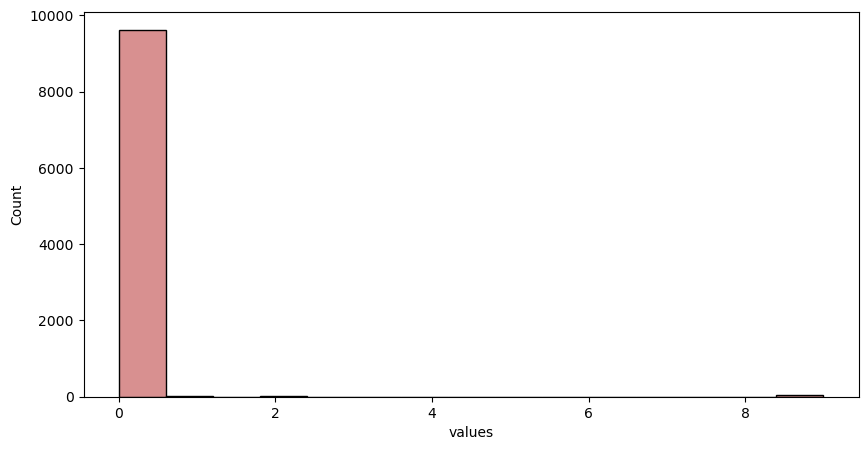

In [14]:
# fix missing data 

print(f"Missing data before clean up: {data.isna().sum().sum()} in total")
print(f"Unique entries (rows): {data.shape[0]}")
if table_is_proteoform:
    print(f"Dominants proteofroms: {data.index.str.contains("sim").sum()}")
    print(f"Alternative proteofroms: {(~data.index.str.contains("sim")).sum()}")

fig, ax = plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(data.isna().sum(axis=1), columns=["values"], index=data.index).pipe(sns.histplot, x = "values", ax=ax, color="firebrick", alpha=0.5)
plt.show()
plt.close()

Missing data after clean up: 522 in total
Unique entries (rows): 9696
Dominants proteofroms: 9187
Alterntive proteofroms: 509


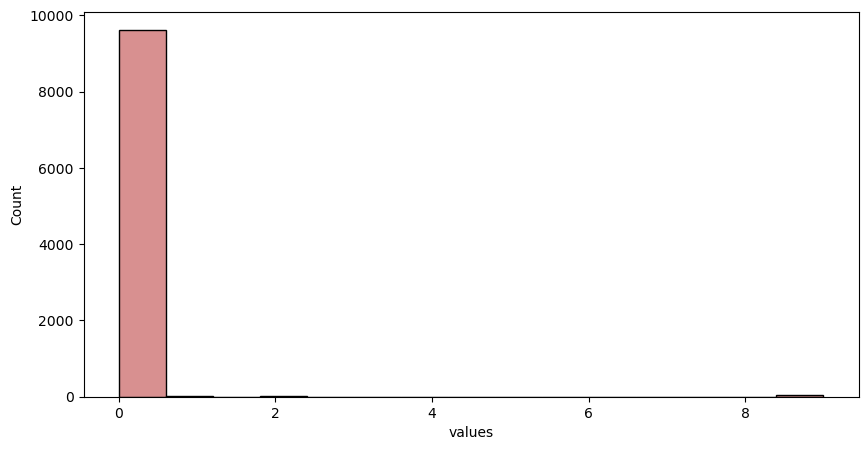

In [15]:
data = data.loc[np.isnan(data).sum(axis=1) < data.shape[1]*0.5]
print(f"Missing data after clean up: {data.isna().sum().sum()} in total")
print(f"Unique entries (rows): {data.shape[0]}")
if table_is_proteoform:
    print(f"Dominants proteofroms: {data.index.str.contains("sim").sum()}")
    print(f"Alterntive proteofroms: {(~data.index.str.contains("sim")).sum()}")
fig, ax = plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(data.isna().sum(axis=1), columns=["values"], index=data.index).pipe(sns.histplot, x = "values", ax=ax, color="firebrick", alpha=0.5)
plt.show()


In [16]:
if table_is_proteoform:
    print(f"Unique dominant proteoforms with gene symbol match")
    mask2 = meta_data["membership"] == "sim"
    mask = meta_data["id"].str.contains("sim")
    print(meta_data.loc[meta_data["membership"] == "sim"].nunique())
else:
    print("This part is ommited for gene centric analysis")

Unique dominant proteoforms with gene symbol match
peptide               8128
ioi                    448
membership               1
id                     448
q_value_proteoform       0
fc_proteoform            0
q_value_protein        140
fc_protein             448
gene_symbol            447
isoforms                67
act-site                 0
binding                  0
carbohyd                 0
coiled                   0
crosslnk                 0
disulfide                0
DNA-bind                 0
domain                   0
helix                    0
init_meth                0
intramem                 0
lipid                    0
mod-res                  0
motif                    0
mutagen                  0
propep                   0
region                   0
repeat                   0
signal                   0
site                     0
strand                   0
topo-dom                 0
transit                  0
transmem                 0
turn                     0
Zn-f

In [17]:
data.isna().sum().sum()
(data.isna().sum(axis=1) > 0.5*data.shape[1]).sum()

np.int64(0)

In [18]:
if table_is_proteoform:
    # here we keep only the dominant proteoform and substitute the index with gene symbols
    
    data_sim = data.loc[data.index.str.contains("sim")]

    # slice the P_sim and keep only the ensemble ID in the index
    data_sim.index = data_sim.index.str.extract(r"(ENSG\d+)")[0]

    # remove indec column name
    data_sim.index.name = None

    # final step substitute index names with gene symbols using the map df
    data_sim.index = data_sim.index.map(mapping)

    # drop NAs in index
    data_sim = data_sim.loc[~data_sim.index.isna()]

    # remove entries with more than 2 gene symbols for now
    mask = data_sim.index.str.match(r'^\w+$')
    data_sim = data_sim[mask]
    
    # how many of these dominants are also in the ground truth dataframe 
    proteins_in_pairs = set(pairs_df.iloc[:, 0]).union(set(pairs_df.iloc[:, 1]))
    datasim_sub = data_sim.loc[data_sim.index.intersection(proteins_in_pairs)].index.nunique()
    print(f"Unique dominant proteoforms with a gene-symbol match within the ground truth databases: {datasim_sub}")

    # finally we substitute the data with the data_sim, to proceed with the analysis
    data = data_sim.copy()
    npdata = data.to_numpy()

    # save the data_sim for later use
    data_sim.to_csv(os.getcwd() + "\\data\\features\\abms_quant_sims.csv", index=True, header=True)
    
else:
    print("This part is ommited during gene centric analysis")

Unique dominant proteoforms with a gene-symbol match within the ground truth databases: 3033


### Data Transformations
- After testing, for my specific tables, non-transformed data works best. 

In [15]:
# # Get extreme values (non-missing) frome ach row. 
# data_min = np.nanmin(npdata, axis=1, keepdims=True)  # minimum among non-NaN
# data_max = np.nanmax(npdata, axis=1,keepdims=True)  # maximum among non-NaN

# # check that that shapes and values are as expected 
# print(data_max.shape,data_min.shape,np.isnan(data_max).sum(), np.isnan(data_min).sum())

In [16]:
# # scale data min-max
# npdata_scaled = (npdata - data_min) /(data_max - data_min + 1e-8)
# npdata_scaled.shape

# # npscbc_scaled[0:2,]

In [350]:
# try a z-score normalization
npdata_scaled = StandardScaler().fit_transform(npdata.T).T

# min max normalization 
# npdata_scaled = MinMaxScaler().fit_transform(npdata.T).T

# # data not scaled works better 
# npdata_scaled = npdata.copy()


In [ ]:
# np.nanmean(npdata)

np.float64(-0.013483470464148677)

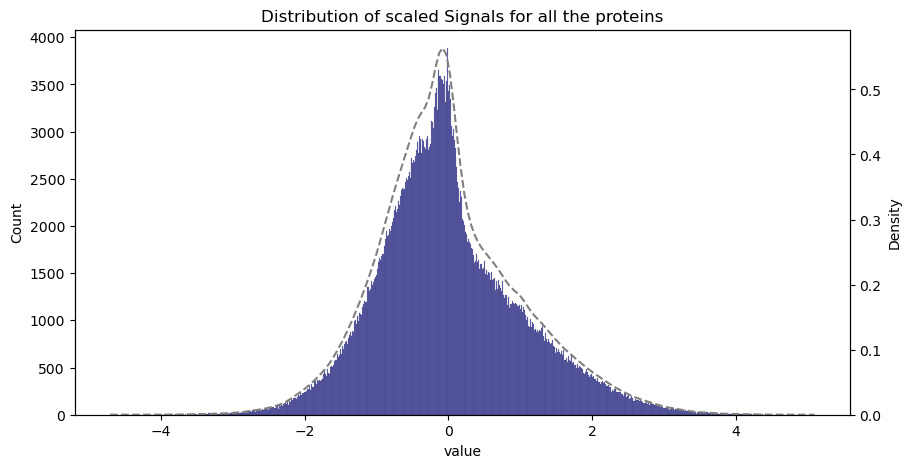

In [351]:
# distribution of all the proteome signals - keep the protein names for outlier analysis 
fig, ax = plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(npdata_scaled, columns=data.columns).melt().pipe((sns.histplot, "data"), x="value", binwidth=.0125, ax=ax, color="darkblue", alpha=.6)
ax2 = ax.twinx()
sns.kdeplot(pd.DataFrame(npdata_scaled, columns=data.columns).melt(),x = "value", ax=ax2, color="gray", ls = "--")
# ax.set_xlim(-4,5)
ax.set_title("Distribution of scaled Signals for all the proteins")
plt.show()

In [352]:
# shuffle the rows but keep scaled original
npdata_scaled_shuffled = npdata_scaled.copy()
np.random.shuffle(npdata_scaled_shuffled)
# npscbc_scaled[1,],scbc.iloc[1,:12]


### Split Data 

In [354]:
train_data, val_data, test_data = uf.create_data_partition(
    npdata_scaled_shuffled, test_perc=0.15, val=True, val_perc=0.1
)
train_data.shape, val_data.shape, test_data.shape

((6828, 54), (911, 54), (1366, 54))

You can test reproducibility by re-runing the function and checking the data in the first index of the matrix. We expect it to be the same. 

### Pass data to Custom Dataset and DataLoaders 
- check that your data is numpy matrix.
- check if data is scaled to (0,1).
- create three custom dataset instances.
- the custom dataset will save all the data to memory and create a mask where NaNs are located.
- the numpy arrays will be converted to tensors of appropriate dimensions and NaNs to zeroes.
- then we pass the custom dataset to the dataloader object.
- The DataLoader object contains for each row (training example) i) a tensor of 1 x 130 columns with 0-1 scaled values, ii) a 1x130 mask indicating NA positions and iii) index of the examples per batch (could be 64, 128,..., batch_size). 

In [355]:
train_dataset = cd.ProteinDataset(train_data)
val_dataset = cd.ProteinDataset(val_data)
test_dataset = cd.ProteinDataset(test_data)
whole_dataset = cd.ProteinDataset(npdata_scaled)

Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified


In [357]:
# pass data to the dataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,drop_last=True)
whole_loader = DataLoader(whole_dataset, batch_size=128, shuffle=False, drop_last=False)

## VAE (Total Cell / ABMS) dimensions optimization Loop with secondary task 
- After some testing, the VAE for the ABMS (total cell) proteoform or protein tables will run without scaling the data. This means no activation function will be applied to the output of the VAE, the reconstructions. Gaussilan Likelihood error applies as a very good reconstruction error loss function (see the distribution of the signals above).

In [358]:
# set the combinations of the VAE layers to check. 
comb_list = list()
for comb in list(itertools.product([54,50, 45,40,30],[30,25,20,15])):
    if comb[0] >= 1.5*comb[1]:
        comb_list.append(comb)

In [359]:
comb_list = [(54,30)]

In [360]:
# dimlist = [(54,30)]
# future for loop for at least 10 different seeds 
outer_final_df = None
outer_metrics_df = None

for s, seed in enumerate([12,13,14,15,16,17,18,19,20,22]):
    
    # if s > 3:
    #     break

    # here we concatanate all the dataframes that are generated per seed (with all the different combinations)
    # set the umap function for the embeddings 
    umap_model = umap.UMAP(n_neighbors=30,
                           min_dist=0.2,
                           n_components=3,
                           metric="euclidean",
                           random_state=seed)

    seed = seed
    torch.manual_seed(seed)

    # here we store the metrics of the models for one seed 
    final_df = None
    final_feature_df = None
    model_list = []

    # iterate over the combinations of the VAE layers 
    for i, tup in enumerate(comb_list):
        hidden_dim, latent_dim, n = tup[0], tup[1], i
        print(seed,i, hidden_dim, latent_dim)

        # Instantiate the model
        model1 = v1.VAE(
            n_features=54,
            latent_dim=latent_dim,
            hidden_layer=True,
            hidden_dim=hidden_dim,
            output_activ=None, # nn.Sigmoid() if scaled to 0-1 
        ).to(device)

        # need to set the model name with the layers - usefull for creating its unique folder 
        model_name = f"abms.sim_noscale_{n}_{hidden_dim}_{latent_dim}"
        model_list.append(model_name)
        # the optimizer is in the train-val loop 


        ## Create a "models" folder and the specifics model's directory to save figures  

        # create the models directory path 
        path_dir = os.getcwd() + "\\models"

        # Check if the models directory exists, if not, create it
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
            print(f"Created directory: {path_dir}")
        else:
            print(f"Directory already exists: {path_dir}")

        # create a subdirectory for each model based on #number and name (the dims of layers)
        model_path = os.path.join(path_dir,model_name)
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        model_path


        ## Final Important part

        # set all the parameters to variables because all functions depend on them
        model = model1
        loss_fun = cf.loss_fun_gauss
        model_name=model_name
        path=model_path
        epoch = 200
        learn_r = 0.0025
        freebits = 4
        batch_size = 128
        norm = 0

        # the path where this model is going to be saved 
        print(f"model path {path}")

        # run the training for the model
        # Run the loop - see the parameters 

        batch_dict, epoch_dict,hyperparam_str = uf.train_val_loop_v3(
        model = model,
        train_loader=train_loader,
        val_loader=val_loader, 
        loss_fun = loss_fun,
        model_name=model_name,
        model_path=path,
        epoch = epoch,
        patience = 7,
        learn_r = learn_r,
        freebits = freebits,
        batch_size = batch_size,
        norm = norm
        )

        # write the full model id
        model_id = model_name + "_" + hyperparam_str
        print(f"Model: {model_id} has been trained")


        # next run the test set analysis for the eaxh model and get the results test_iter_dict and test_metrics 
        test_iter_dict, test_metrics = uf.test_set_analysis(
        model=model,
        test_loader=test_loader,
        loss_fun = loss_fun,
        freebits=freebits,
        model_id=model_id
    )
        # create the the dataframe to store per model metrics 
        test_df = pd.DataFrame([test_metrics])
        test_df["hidden_dim"] = hidden_dim
        test_df["latent_dim"] = latent_dim
        test_df["seed"] = seed
        
        # extract latent variables from the whole dataset using the trained model
        # latent list
        latent_list = list()
        with torch.inference_mode():
            model.eval()
            for batch, _, _ in whole_loader:
                batch = batch.to(device)
                latent, _ = model.get_latent_variables(batch, detach=True)
                latent_list.append(latent.cpu().detach().numpy())
            
        latent_arr = np.vstack(latent_list)
        latent_df = pd.DataFrame(latent_arr, index=data.index, columns=[f"z{str(i)}" for i in range(latent_dim)])

        # after gettng the latent variables perform umap on them 
        umap_latent = umap_model.fit_transform(latent_df)
        umap_df = pd.DataFrame(umap_latent, index=data.index, columns=[f"dim1",f"dim2",f"dim3"])


        # thing to remove after the iteration is finished umap_latent, latent_df, umap_dist 
        if final_df is None:
            final_df = test_df
        else:
            final_df = pd.concat([final_df,test_df],axis=0)
        
        gc.collect()

        # get the feature from the specific model parameters
    
        # proteins that exist withing ground truth databases
        proteins_in_pairs = set(pairs_df.iloc[:, 0]).union(set(pairs_df.iloc[:, 1]))

        # subset by what is in the ground truth pairs
        latent_df_sub = latent_df.loc[latent_df.index.intersection(proteins_in_pairs)]
        umap_df_sub = umap_df.loc[umap_df.index.intersection(proteins_in_pairs)]


        # perform corralation analysis for latent and euclidean distance calculation for umap embeddings



        corr_matrix = pd.DataFrame(np.corrcoef(latent_df_sub),
                                index=latent_df_sub.index,
                                columns=latent_df_sub.index)

        # fix the matrices of each feature type 

        cor_feat = (corr_matrix
                    .reset_index()
                    .melt(id_vars="index", var_name="Var2", value_name=f"cor_feature_{model_name}")
                    .rename(columns={"index":"Var1"})
        )

        ##
        umap_dist = pd.DataFrame(pairwise_distances(umap_df_sub, metric="euclidean"),
                                index = umap_df_sub.index,
                                columns=umap_df_sub.index)

        umap_dist = umap_dist.reset_index().melt(id_vars="index", var_name="Var2", value_name=f"euc_feature_{model_name}").rename(columns={"index":"Var1"})



        ## filter duplicates and self-correlations/distances, keep only Var1>Var2
        cor_feat = cor_feat[cor_feat["Var1"]!=cor_feat["Var2"]]
        cor_feat = cor_feat[cor_feat["Var1"]>cor_feat["Var2"]]

        umap_dist = umap_dist[umap_dist["Var1"]!=umap_dist["Var2"]]
        umap_dist = umap_dist[umap_dist["Var1"]>umap_dist["Var2"]]


        ## get a true protein pairs character vector
        pair_chars = pairs_df["V1"].astype(str) + "_" + pairs_df["V2"].astype(str)

        ## get ground truth classes of each feature category
        cor_feat["db"] = np.where((cor_feat["Var1"].astype(str) + "_" + cor_feat["Var2"].astype(str)).isin(pair_chars), 1, 0)
        umap_dist["db"] = np.where((umap_dist["Var1"].astype(str) + "_" + umap_dist["Var2"].astype(str)).isin(pair_chars), 1, 0)

        # merge both dataframes using reduce and lambda function
        feature_df = reduce(lambda left, right: pd.merge(left, right, on=["Var1", "Var2", "db"], how="inner"), [cor_feat, umap_dist])

        if final_feature_df is None:
            final_feature_df = feature_df
        else:
            final_feature_df = reduce(lambda left, right: pd.merge(left, right, on=["Var1", "Var2", "db"], how="inner"), [final_feature_df, feature_df])
        
        del cor_feat, umap_dist, pair_chars, corr_matrix, latent_df_sub, umap_df_sub, umap_latent, feature_df
        
        gc.collect()


    # out of the first loop 


    # create cor features from the base 
    proteins_in_pairs = set(pairs_df.iloc[:, 0]).union(set(pairs_df.iloc[:, 1]))

    data_sub = data.loc[data.index.intersection(proteins_in_pairs)]
    corr_matrix_base = data_sub.T.corr(method="pearson")

    cor_feat_base = (corr_matrix_base
                .reset_index()
                .melt(id_vars="index", var_name="Var2", value_name=f"cor_base")
                .rename(columns={"index":"Var1"})
    )
    cor_feat_base = cor_feat_base[cor_feat_base["Var1"]!=cor_feat_base["Var2"]]
    cor_feat_base = cor_feat_base[cor_feat_base["Var1"]>cor_feat_base["Var2"]]

    pair_chars = pairs_df["V1"].astype(str) + "_" + pairs_df["V2"].astype(str)
    cor_feat_base["db"] = np.where((cor_feat_base["Var1"].astype(str) + "_" + cor_feat_base["Var2"].astype(str)).isin(pair_chars), 1, 0) 

    # add the base cor-predictor to the feature list as well as to the model list
    model_list.append("cor_base")
    final_feature_df= final_feature_df.merge(cor_feat_base, on=["Var1","Var2","db"], how="inner")




    ###### from this part and so on feature extraction for all combinations ######
    metrics_df = None
    # all combinations should be based on the same sampling procedure for more accurate comparisons 

    # begin with the L2 regression 
    pos_df = final_feature_df[final_feature_df['db'] == 1]
    neg_df = final_feature_df[final_feature_df['db'] == 0]

    # sample the negatives with randomization and create final dataset df
    neg_df = neg_df.sample(n=pos_df.shape[0], random_state=seed)
    sample_df = pd.concat([pos_df,neg_df]).sample(frac=1, random_state=seed)
    del pos_df, neg_df

    X = sample_df.drop(["Var1", "Var2", "db"], axis=1) 
    # umapX = sample_df[["euc_feature"]]
    y = sample_df["db"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    classifier_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(penalty="l2", solver="liblinear", random_state=seed))
    ])

    param_grid = {
        'logreg__C': [0.01]
    }

    for model_n in model_list:
        print(model_n)
        if model_n != "cor_base":

            # base_cor_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)
            cor_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)
            euc_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)


            # base_cor_grid.fit(X_train[["cor_base"]], y_train)
            cor_grid.fit(X_train[[f"cor_feature_{model_n}"]], y_train)
            euc_grid.fit(X_train[[f"euc_feature_{model_n}"]], y_train)

            # basecor_cv_auc = base_cor_grid.best_score_
            cor_cv_auc = cor_grid.best_score_
            euc_cv_auc = euc_grid.best_score_

            # y_pred_basecor = base_cor_grid.predict_proba(X_test[["cor_base"]])[:, 1]
            y_pred_cor = cor_grid.predict_proba(X_test[[f"cor_feature_{model_n}"]])[:, 1]
            y_pred_euc = euc_grid.predict_proba(X_test[[f"euc_feature_{model_n}"]])[:, 1]

            # basecor_test_auc = roc_auc_score(y_test, y_pred_basecor)
            cor_test_auc = roc_auc_score(y_test, y_pred_cor)
            euc_test_auc = roc_auc_score(y_test, y_pred_euc)

            # final_df["test_basecor"] = round(float(basecor_test_auc),3)
            res_df = pd.DataFrame({
                    "model" : [model_n],
                    "test_cor" : [round(float(cor_test_auc),3)],
                    "test_umap" : [round(float(euc_test_auc),3)],
                    "seed" : seed
                })

            if metrics_df is None:
                metrics_df = res_df
            else:
                metrics_df = pd.concat([metrics_df,res_df],axis=0)
            
            gc.collect()
        
        # potential issue when after correlation there are NAs, beacuse the proteins may not have overlapping samples (identify them)
        else:
            cor_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)
            cor_grid.fit(X_train[[model_n]], y_train)
            y_pred_cor = cor_grid.predict_proba(X_test[[model_n]])[:, 1]
            cor_test_auc = roc_auc_score(y_test, y_pred_cor)
            res_df = pd.DataFrame({
                    "model" : [model_n],
                    "test_cor" : [round(float(cor_test_auc),3)],
                    "test_umap" : 0,
                    "seed" : seed
                })
            
            if metrics_df is None:
                metrics_df = res_df
            else:
                metrics_df = pd.concat([metrics_df,res_df],axis=0)

    del X_train, X_test, y_train, y_test, param_grid, classifier_pipe, res_df
    gc.collect()


    if outer_final_df is None:
        outer_final_df = final_df
    else:
        outer_final_df = pd.concat([outer_final_df, final_df], axis=0)

    if outer_metrics_df is None:
        outer_metrics_df = metrics_df
    else:
        outer_metrics_df = pd.concat([outer_metrics_df, metrics_df], axis=0)
    # last step - make predictions for this batch of features


outer_final_df.shape, outer_metrics_df.shape 

12 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.647| Val KL: 83.17765045166016 | Val Rec: 1.470

Patience exceeded at 71 with last checkpoint saved at 63
changed learning rate to 0.001
Early stopping at epoch 90 with last checkpoint saved at 79
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep79_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep79_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
13 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.650| Val KL: 83.17765045166016 | Val Rec: 1.472

Patience exceeded at 51 with last checkpoint saved at 43
changed learning rate to 0.001
Early stopping at epoch 71 with last checkpoint saved at 60
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep60_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep60_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
14 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.649| Val KL: 83.17765045166016 | Val Rec: 1.471

Patience exceeded at 63 with last checkpoint saved at 55
changed learning rate to 0.001
Early stopping at epoch 109 with last checkpoint saved at 98
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep98_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep98_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
15 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.649| Val KL: 83.17765045166016 | Val Rec: 1.471

Patience exceeded at 50 with last checkpoint saved at 42
changed learning rate to 0.001
Early stopping at epoch 84 with last checkpoint saved at 73
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep73_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep73_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
16 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.650| Val KL: 83.17765045166016 | Val Rec: 1.472

Patience exceeded at 51 with last checkpoint saved at 43
changed learning rate to 0.001
Early stopping at epoch 82 with last checkpoint saved at 71
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep71_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep71_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
17 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.643| Val KL: 83.17765045166016 | Val Rec: 1.465

Patience exceeded at 66 with last checkpoint saved at 58
changed learning rate to 0.001
Early stopping at epoch 105 with last checkpoint saved at 94
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep94_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep94_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
18 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.649| Val KL: 83.17765045166016 | Val Rec: 1.471

Patience exceeded at 58 with last checkpoint saved at 50
changed learning rate to 0.001
Early stopping at epoch 70 with last checkpoint saved at 59
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep59_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep59_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
19 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.647| Val KL: 83.17765045166016 | Val Rec: 1.470

Patience exceeded at 51 with last checkpoint saved at 43
changed learning rate to 0.001
Early stopping at epoch 74 with last checkpoint saved at 63
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep63_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep63_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
20 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.651| Val KL: 83.17765045166016 | Val Rec: 1.474

Patience exceeded at 64 with last checkpoint saved at 56
changed learning rate to 0.001
Early stopping at epoch 118 with last checkpoint saved at 107
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep107_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep107_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base
22 0 54 30
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 84.646| Val KL: 83.17765045166016 | Val Rec: 1.468

Patience exceeded at 56 with last checkpoint saved at 48
changed learning rate to 0.001
Early stopping at epoch 80 with last checkpoint saved at 69
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\abms.sim_noscale_0_54_30
Model: abms.sim_noscale_0_54_30_ep69_norm0_bits4_bs128_lr0.001 has been trained
Using this model abms.sim_noscale_0_54_30_ep69_norm0_bits4_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


abms.sim_noscale_0_54_30
cor_base


((10, 8), (20, 4))

In [361]:
outer_metrics_df.groupby(["model"]).mean()

,test_cor,test_umap,seed
model,,,
abms.sim_noscale_0_54_30,0.7172,0.7039,16.6
cor_base,0.7182,0.0000,16.6


In [349]:
outer_metrics_df

,model,test_cor,test_umap,seed
0,abms.sim_noscale_0_54_30,0.717,0.718,12
0,cor_base,0.715,0.000,12
0,abms.sim_noscale_0_54_30,0.713,0.728,13
0,cor_base,0.714,0.000,13
0,abms.sim_noscale_0_54_30,0.721,0.725,14
0,cor_base,0.722,0.000,14
0,abms.sim_noscale_0_54_30,0.721,0.725,15
0,cor_base,0.722,0.000,15
0,abms.sim_noscale_0_54_30,0.719,0.713,16
0,cor_base,0.711,0.000,16


In [ ]:
outer_metrics_df.to_csv(os.getcwd()+"\\data\\processed\\abms4sim__noscale_metrics.csv")
outer_final_df.to_csv(os.getcwd()+"\\data\\processed\\abms4sim_noscale_finaldf.csv")

In [ ]:
pd.read_csv(os.getcwd()+"\\data\\processed\\abms_iter_minmax_finaldf.csv")

,Unnamed: 0,model_id,bits,avg_total_loss,avg_kl_loss,avg_rl_loss,hidden_dim,latent_dim,seed
0,0,abms_iter_0_54_30_ep79_norm0_bits4_bs128_lr0.001,4,82.134689,83.179327,-1.044638,54,30,12
1,0,abms_iter_1_54_25_ep71_norm0_bits4_bs128_lr0.001,4,68.278259,69.315375,-1.037116,54,25,12
2,0,abms_iter_2_54_20_ep86_norm0_bits4_bs128_lr0.001,4,54.425391,55.452838,-1.027448,54,20,12
3,0,abms_iter_3_54_15_ep89_norm0_bits4_bs128_lr0.001,4,40.663236,41.589298,-0.926061,54,15,12
4,0,abms_iter_4_50_30_ep103_norm0_bits4_bs128_lr0.001,4,82.151190,83.178384,-1.027193,50,30,12
...,...,...,...,...,...,...,...,...,...
165,0,abms_iter_12_40_25_ep73_norm0_bits4_bs128_lr0.001,4,68.384246,69.315377,-0.931131,40,25,22
166,0,abms_iter_13_40_20_ep90_norm0_bits4_bs128_lr0.001,4,54.552166,55.452319,-0.900153,40,20,22
167,0,abms_iter_14_40_15_ep59_norm0_bits4_bs128_lr0.001,4,40.766201,41.589211,-0.823011,40,15,22
168,0,abms_iter_15_30_20_ep74_norm0_bits4_bs128_lr0.001,4,54.645410,55.452005,-0.806596,30,20,22


### Checkpoint

##  Data Preparation and split for VAE (Subcell Proteomics)
- We will perform **min-max or zscore scaling** to the TMT-Ratios of the proteomic SCBC data. <br>
- We will scale the array version of our scbc data, the `npdata` matrix. The output is the `npdata_scaled`.
- Then we will copy this scaled matrix and reshuffle the copy. The `npscbc_scaled_shuffled` will be used for the model training and performance evaluattion. <br>
- The `npdata_scaled` matrix with the original order of rows will be used later for the validation and extraction of the latent variables. <br> 

In [19]:
# create path and read the scbc data
data_path = os.getcwd() + "\\data\\processed\\" 

# SCBC Pan-Can Data - protein (gene centric) tables
# data = pd.read_csv(data_path+"protein_quant_merged.txt",delimiter="\t")

# convert to numpy
# npdata = data.to_numpy()



                        ## GROUND TRUTH PAIRS FROM CORM & COMPLEAT ## 
# load groudtruth pairs 
pairs_df = pd.read_csv(os.getcwd() + "\\data\\processed\\" + "merged_pairs.txt", delimiter="\t")



                        ## FOR PROTEOFORM ANALYSIS HERE ## 
# SCBC Pan-Can proteoform dataset (SCBC proteoform tables)
data = pd.read_csv(os.getcwd() + "\\data\\raw\\SCBC2_proteoform_table 2.txt",delimiter="\t")
meta_data = pd.read_csv(os.getcwd() + "\\data\\raw\\SCBC2_summarized_proteoforms_sig_annotated_groups_vertical.txt",delimiter="\t")



# ensemble ID to gene symbol mapping for SCBC proteoform table 
map_df = pd.read_csv(os.getcwd() + "\\data\\raw\\SCBC2_gene_id_to_symbol.txt",delimiter="\t")
# one to one map of ensemble IDs to gene symbols
mapping = dict(zip(map_df["gene_id"], map_df["gene_name"]))





table_is_proteoform = True  # CHANGE IT TO TRUE IF YOU RUN A PROTEOFORM TABLE

C:\Users\gpano\AppData\Local\Temp\ipykernel_3524\500142395.py:21: DtypeWarning: Columns (9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv(os.getcwd() + "\\data\\raw\\SCBC2_summarized_proteoforms_sig_annotated_groups_vertical.txt",delimiter="\t")


###  Evaluate NAs and unique entries from the Dataset
- For missing values I wll keep rows with > 50% non-missing Values. The VAE can tolerate this much. 
- The part for the unique entries is mostly for the proteoform tables. 
- There are dominant proteoforms named with the prefix "sims" in the tables. These sim proteoforms should match to unique gene symbols in the meta data table. Basicaly it is the dominant form of its respective protein. The meta-table contains the dominant forms, who also a have an alternative proteoform. For Subcellular data, of all the 15058 dominants, 7394 have at least one alternative proteoform. 

Missing data before clean up: 1296508 in total
Unique entries (rows): 27073
Dominants proteofroms: 15058
Alternative proteofroms: 12015


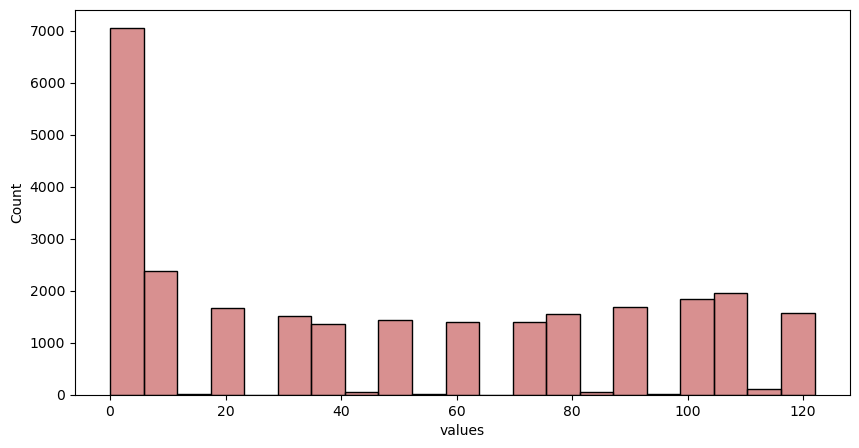

In [21]:
# fix missing data 

print(f"Missing data before clean up: {data.isna().sum().sum()} in total")
print(f"Unique entries (rows): {data.shape[0]}")
if table_is_proteoform:
    print(f"Dominants proteofroms: {data.index.str.contains("sim").sum()}")
    print(f"Alternative proteofroms: {(~data.index.str.contains("sim")).sum()}")

fig, ax = plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(data.isna().sum(axis=1), columns=["values"], index=data.index).pipe(sns.histplot, x = "values", ax=ax, color="firebrick", alpha=0.5)
plt.show()
plt.close()

Missing data after clean up: 102937 in total
Unique entries (rows): 12622
Dominants proteofroms: 8255
Alterntive proteofroms: 4367


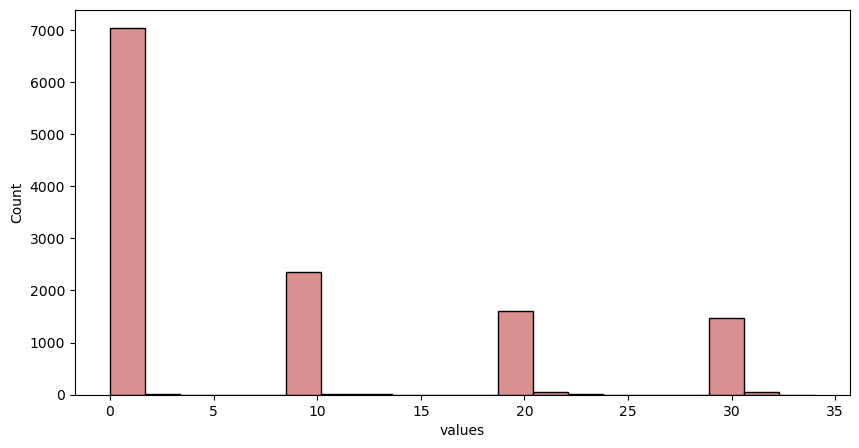

In [22]:
data = data.loc[np.isnan(data).sum(axis=1) < data.shape[1]*0.3]
print(f"Missing data after clean up: {data.isna().sum().sum()} in total")
print(f"Unique entries (rows): {data.shape[0]}")
if table_is_proteoform:
    print(f"Dominants proteofroms: {data.index.str.contains("sim").sum()}")
    print(f"Alterntive proteofroms: {(~data.index.str.contains("sim")).sum()}")
fig, ax = plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(data.isna().sum(axis=1), columns=["values"], index=data.index).pipe(sns.histplot, x = "values", ax=ax, color="firebrick", alpha=0.5)
plt.show()


In [23]:
if table_is_proteoform:
    print(f"Unique dominant proteoforms with gene symbol match")
    mask2 = meta_data["membership"] == "sim"
    mask = meta_data["id"].str.contains("sim")
    print(meta_data.loc[meta_data["membership"] == "sim"].nunique())
else:
    print("This part is ommited for gene centric analysis")

Unique dominant proteoforms with gene symbol match
peptide               898972
ioi                     7934
membership                 1
id                      7934
q_value_proteoform         0
fc_proteoform              0
q_value_protein         1199
fc_protein              7934
gene_symbol             7860
isoforms                 484
act-site                   0
binding                    0
carbohyd                   0
coiled                     0
crosslnk                   0
disulfide                  0
DNA-bind                   0
domain                     0
helix                      0
init_meth                  0
intramem                   0
lipid                      0
mod-res                    0
motif                      0
mutagen                    0
propep                     0
region                     0
repeat                     0
signal                     0
site                       0
strand                     0
topo-dom                   0
transit              

In [24]:
if table_is_proteoform:
    # here we keep only the dominant proteoform and substitute the index with gene symbols
    
    data_sim = data.loc[data.index.str.contains("sim")]

    # slice the P_sim and keep only the ensemble ID in the index
    data_sim.index = data_sim.index.str.extract(r"(ENSG\d+)")[0]

    # remove indec column name
    data_sim.index.name = None

    # final step substitute index names with gene symbols using the map df
    data_sim.index = data_sim.index.map(mapping)

    # drop NAs in index
    data_sim = data_sim.loc[~data_sim.index.isna()]

    # remove entries with more than 2 gene symbols for now
    mask = data_sim.index.str.match(r'^\w+$')
    data_sim = data_sim[mask]
    
    # how many of these dominants are also in the ground truth dataframe 
    proteins_in_pairs = set(pairs_df.iloc[:, 0]).union(set(pairs_df.iloc[:, 1]))
    datasim_sub = data_sim.loc[data_sim.index.intersection(proteins_in_pairs)].index.nunique()
    print(f"Unique dominant proteoforms with a gene-symbol match within the ground truth databases: {datasim_sub}")

    # finally we substitute the data with the data_sim, to proceed with the analysis
    data = data_sim.copy()
    npdata = data.to_numpy()

    # save the data_sim for later use
    data_sim.to_csv(os.getcwd() + "\\data\\features\\scbc_quant_sims.csv", index=True, header=True)
    
else:
    print("This part is ommited during gene centric analysis")

Unique dominant proteoforms with a gene-symbol match within the ground truth databases: 2715


### Data Transformation
- again, if applicable 

In [428]:
data.head(2)

,FS1.A_A375,FS1.B_A375,FS2.A_A375,FS2.B_A375,FP1.A_A375,FP1.B_A375,FP2.A_A375,FP2.B_A375,FP3.A_A375,FP3.B_A375,...,FS1.A_U2OS,FS1.B_U2OS,FS2.A_U2OS,FS2.B_U2OS,FP1.A_U2OS,FP1.B_U2OS,FP2.A_U2OS,FP2.B_U2OS,FP3.A_U2OS,FP3.B_U2OS
TSPAN6,-0.584606,-0.870604,-0.934516,-0.792672,0.441556,-0.135185,0.781125,0.964383,1.143355,1.229895,...,-1.119694,-1.048714,-0.937936,-0.852804,0.619363,0.532614,0.969966,1.054591,1.066931,1.093787
DPM1,-0.954147,-0.745517,-0.931724,-1.022787,0.537996,0.486280,0.946493,1.053681,0.718645,0.799750,...,-0.762266,-0.739394,-0.859660,-0.751788,0.661484,0.443144,0.619505,0.683142,0.831424,0.924285


In [25]:
# Get extreme values (non-missing) from each row. (for min-max)
data_min = np.nanmin(npdata, axis=1, keepdims=True)  # minimum among non-NaN
data_max = np.nanmax(npdata, axis=1,keepdims=True)  # maximum among non-NaN

# check that that shapes and values are as expected 
print(data_max.shape,data_min.shape,np.isnan(data_max).sum(), np.isnan(data_min).sum())

(8208, 1) (8208, 1) 0 0


In [26]:
# # scale data min-max normalization
# npdata_scaled = (npdata - data_min) /(data_max - data_min + 1e-8)
# npdata_scaled.shape

# # scale data z-score normalization
# npdata_scaled = StandardScaler().fit_transform(npdata.T).T
# npdata_scaled.shape

# no scale
npdata_scaled = npdata.copy()

In [27]:
# shuffle the rows but keep scaled original - we need the original to extract the latent variables 
npdata_scaled_shuffled = npdata_scaled.copy()
np.random.shuffle(npdata_scaled_shuffled)

# npscbc_scaled[1,],scbc.iloc[1,:12]

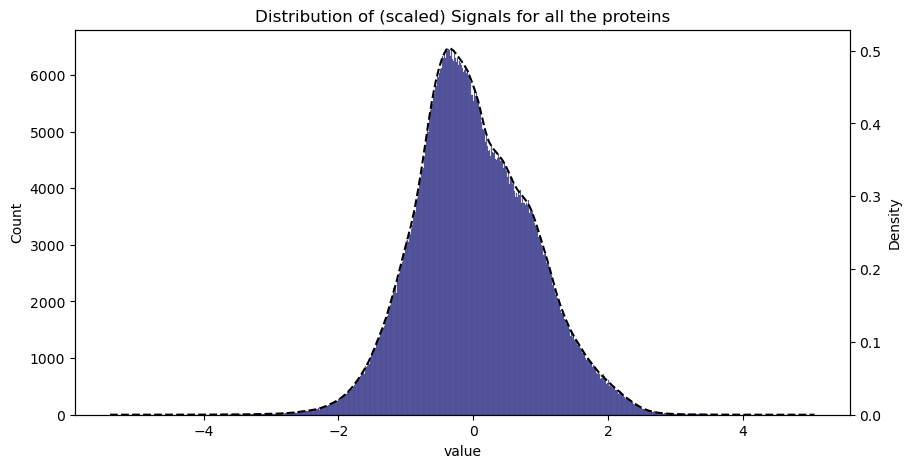

In [28]:
# distribution of all the proteome signals - sanity check for data transformation 
fig, ax = plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(npdata_scaled, columns=data.columns).melt().pipe((sns.histplot, "data"), x="value", binwidth=.0125, ax=ax, color="darkblue", alpha=.6)
ax2 = ax.twinx()
sns.kdeplot(pd.DataFrame(npdata_scaled, columns=data.columns).melt(),x = "value", ax=ax2, color="black", ls = "--")
# ax.set_xlim(-4,5)
ax.set_title("Distribution of (scaled) Signals for all the proteins")
plt.show()


### Split Data 

In [29]:
train_data, val_data, test_data = uf.create_data_partition(
    npdata_scaled_shuffled, test_perc=0.15, val=True, val_perc=0.1
)
train_data.shape, val_data.shape, test_data.shape

((6155, 130), (821, 130), (1232, 130))

You can test reproducibility by re-runing the function and checking the data in the first index of the matrix. We expect it to be the same. 

### Pass data to Custom Dataset and DataLoaders 
- check that your data is numpy matrix.
- check if data is scaled to (0,1).
- create three custom dataset instances.
- the custom dataset will save all the data to memory and create a mask where NaNs are located.
- the numpy arrays will be converted to tensors of appropriate dimensions and NaNs to zeroes.
- then we pass the custom dataset to the dataloader object.
- The DataLoader object contains for each row (training example) i) a tensor of 1 x 130 columns with 0-1 scaled values, ii) a 1x130 mask indicating NA positions and iii) index of the examples per batch (could be 64, 128,..., batch_size). 

In [30]:
train_dataset = cd.ProteinDataset(train_data)
val_dataset = cd.ProteinDataset(val_data)
test_dataset = cd.ProteinDataset(test_data)

# pass the whole dataset not shuffled  
whole_dataset = cd.ProteinDataset(npdata_scaled)

Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified


In [31]:
# pass data to the dataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,drop_last=True)
whole_loader = DataLoader(whole_dataset, batch_size=128, shuffle=False, drop_last=False)

## VAE (SCBC) dimensions optimization Loop with secondary task 


In [32]:
# set the combinations of the VAE layers to check. 
comb_list = list()
for comb in list(itertools.product([90,75,65,50,35],[45,32,25,20,15,10])):
    if comb[0] >= 1.5*comb[1]:
        comb_list.append(comb)

In [33]:
# over write if want to check one particular dimension combination 
comb_list = [(90,45)]

In [34]:
# dimlist = [(54,30)]
# future for loop for at least 10 different seeds 
outer_final_df = None
outer_metrics_df = None

for s, seed in enumerate([22,23,24,25,26,27,28,29,30,31]):

    # # break the loop early (for quick check-ups)
    if s > 1:
        break 
    
    
    # here we concatanate all the dataframes that are generated per seed (with all the different combinations)

    seed = seed
    torch.manual_seed(seed)
    umap_model = umap.UMAP(n_neighbors=30,
                           min_dist=0.15,
                           n_components=3,
                           metric="euclidean",
                           random_state=seed)


    # here we store the metrics of the models for one seed 
    final_df = None
    final_feature_df = None
    model_list = []

    # iterate over the combinations of the VAE layers 
    for i, tup in enumerate(comb_list):
        hidden_dim, latent_dim, n = tup[0], tup[1], i
        print("\n")
        print(f"Testing model: {i}, with dims {hidden_dim} and {latent_dim}, in seed {seed}")
        print("---"*30)

        # Instantiate the model
        model1 = v1.VAE(
            n_features=130,
            latent_dim=latent_dim,
            hidden_layer=True,
            hidden_dim=hidden_dim,
            output_activ=None, #nn.Sigmoid() or nn.Tanh() are other options 
        ).to(device)

        # need to set the model name with the layers - usefull for creating its unique folder 
        model_name = f"scbc2sim04_nocale_{n}_{hidden_dim}_{latent_dim}"
        model_list.append(model_name)
        # the optimizer is in the train-val loop 


        ## Create a "models" folder and the specifics model's directory to save figures  

        # create the models directory path 
        path_dir = os.getcwd() + "\\models"

        # Check if the models directory exists, if not, create it
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
            print(f"Created directory: {path_dir}")
        else:
            print(f"Directory already exists: {path_dir}")

        # create a subdirectory for each model based on #number and name (the dims of layers)
        model_path = os.path.join(path_dir,model_name)
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        model_path


        ## Final Important part

        # set all the parameters to variables because all functions depend on them
        model = model1
        loss_fun = cf.loss_fun_gauss
        model_name=model_name
        path=model_path
        epoch = 200
        learn_r = 0.005
        freebits = 2
        batch_size = 128
        norm = 0

        # the path where this model is going to be saved 
        print(f"model path {path}")

        # run the training for the model
        # Run the loop - see the parameters 

        batch_dict, epoch_dict,hyperparam_str = uf.train_val_loop_v3(
        model = model,
        train_loader=train_loader,
        val_loader=val_loader, 
        loss_fun = loss_fun,
        model_name=model_name,
        model_path=path,
        epoch = epoch,
        patience = 7,
        learn_r = learn_r,
        freebits = freebits,
        batch_size = batch_size,
        norm = norm
        )

        # write the full model id
        model_id = model_name + "_" + hyperparam_str
        print(f"Model: {model_id} has been trained")


        # next run the test set analysis for the eaxh model and get the results test_iter_dict and test_metrics 
        test_iter_dict, test_metrics = uf.test_set_analysis(
        model=model,
        test_loader=test_loader,
        loss_fun = loss_fun,
        freebits=freebits,
        model_id=model_id
    )
        # create the the dataframe to store per model metrics 
        test_df = pd.DataFrame([test_metrics])
        test_df["hidden_dim"] = hidden_dim
        test_df["latent_dim"] = latent_dim
        test_df["seed"] = seed
        
        # extract latent variables from the whole dataset using the trained model
        # latent list
        latent_list = list()
        with torch.inference_mode():
            model.eval()
            for batch, _, _ in whole_loader:
                batch = batch.to(device)
                latent, _ = model.get_latent_variables(batch, detach=True)
                latent_list.append(latent.cpu().detach().numpy())
            
        latent_arr = np.vstack(latent_list)
        latent_df = pd.DataFrame(latent_arr, index=data.index, columns=[f"z{str(i)}" for i in range(latent_dim)])

        # after gettng the latent variables perform umap on them 
        umap_latent = umap_model.fit_transform(latent_df)
        umap_df = pd.DataFrame(umap_latent, index=data.index, columns=[f"dim1",f"dim2",f"dim3"])

        # create the classifier and use the latent dimension and the umap embeddings to the predictor - use df_pairs as ground truth, 

        # thing to remove after the iteration is finished umap_latent, latent_df, umap_dist 
        if final_df is None:
            final_df = test_df
        else:
            final_df = pd.concat([final_df,test_df],axis=0)
        
        gc.collect()

        # get the feature from the specific model parameters
    
        # proteins that exist withing ground truth databases
        proteins_in_pairs = set(pairs_df.iloc[:, 0]).union(set(pairs_df.iloc[:, 1]))

        # subset by what is in the ground truth pairs
        latent_df_sub = latent_df.loc[latent_df.index.intersection(proteins_in_pairs)]
        umap_df_sub = umap_df.loc[umap_df.index.intersection(proteins_in_pairs)]


        # perform corralation analysis for latent and euclidean distance calculation for umap embeddings



        corr_matrix = pd.DataFrame(np.corrcoef(latent_df_sub),
                                index=latent_df_sub.index,
                                columns=latent_df_sub.index)

        # fix the matrices of each feature type 

        cor_feat = (corr_matrix
                    .reset_index()
                    .melt(id_vars="index", var_name="Var2", value_name=f"cor_feature_{model_name}")
                    .rename(columns={"index":"Var1"})
        )

        ##
        umap_dist = pd.DataFrame(pairwise_distances(umap_df_sub, metric="euclidean"),
                                index = umap_df_sub.index,
                                columns=umap_df_sub.index)

        umap_dist = umap_dist.reset_index().melt(id_vars="index", var_name="Var2", value_name=f"euc_feature_{model_name}").rename(columns={"index":"Var1"})



        ## filter duplicates and self-correlations/distances, keep only Var1>Var2
        cor_feat = cor_feat[cor_feat["Var1"]!=cor_feat["Var2"]]
        cor_feat = cor_feat[cor_feat["Var1"]>cor_feat["Var2"]]

        umap_dist = umap_dist[umap_dist["Var1"]!=umap_dist["Var2"]]
        umap_dist = umap_dist[umap_dist["Var1"]>umap_dist["Var2"]]


        ## get a true protein pairs character vector
        pair_chars = pairs_df["V1"].astype(str) + "_" + pairs_df["V2"].astype(str)

        ## get ground truth classes of each feature category
        cor_feat["db"] = np.where((cor_feat["Var1"].astype(str) + "_" + cor_feat["Var2"].astype(str)).isin(pair_chars), 1, 0)
        umap_dist["db"] = np.where((umap_dist["Var1"].astype(str) + "_" + umap_dist["Var2"].astype(str)).isin(pair_chars), 1, 0)

        # merge both dataframes using reduce and lambda function
        feature_df = reduce(lambda left, right: pd.merge(left, right, on=["Var1", "Var2", "db"], how="inner"), [cor_feat, umap_dist])

        if final_feature_df is None:
            final_feature_df = feature_df
        else:
            final_feature_df = reduce(lambda left, right: pd.merge(left, right, on=["Var1", "Var2", "db"], how="inner"), [final_feature_df, feature_df])
        
        del cor_feat, umap_dist, pair_chars, corr_matrix, latent_df_sub, umap_df_sub, umap_latent, feature_df
        
        gc.collect()


    # out of the first loop 


    # create cor features from the base 
    proteins_in_pairs = set(pairs_df.iloc[:, 0]).union(set(pairs_df.iloc[:, 1]))

    data_sub = data.loc[data.index.intersection(proteins_in_pairs)]
    corr_matrix_base = data_sub.T.corr(method="pearson")

    cor_feat_base = (corr_matrix_base
                .reset_index()
                .melt(id_vars="index", var_name="Var2", value_name=f"cor_base")
                .rename(columns={"index":"Var1"})
    )
    cor_feat_base = cor_feat_base[cor_feat_base["Var1"]!=cor_feat_base["Var2"]]
    cor_feat_base = cor_feat_base[cor_feat_base["Var1"]>cor_feat_base["Var2"]]

    pair_chars = pairs_df["V1"].astype(str) + "_" + pairs_df["V2"].astype(str)
    cor_feat_base["db"] = np.where((cor_feat_base["Var1"].astype(str) + "_" + cor_feat_base["Var2"].astype(str)).isin(pair_chars), 1, 0) 

    # add the base cor-predictor to the feature list as well as to the model list
    model_list.append("cor_base")
    final_feature_df= final_feature_df.merge(cor_feat_base, on=["Var1","Var2","db"], how="inner")




    ###### from this part and so on feature extraction for all combinations ######
    metrics_df = None
    # all combinations should be based on the same sampling procedure for more accurate comparisons 

    # begin with the L2 regression 
    pos_df = final_feature_df[final_feature_df['db'] == 1]
    neg_df = final_feature_df[final_feature_df['db'] == 0]

    # sample the negatives with randomization and create final dataset df
    neg_df = neg_df.sample(n=pos_df.shape[0], random_state=seed)
    sample_df = pd.concat([pos_df,neg_df]).sample(frac=1, random_state=seed)
    del pos_df, neg_df

    X = sample_df.drop(["Var1", "Var2", "db"], axis=1) 
    # umapX = sample_df[["euc_feature"]]
    y = sample_df["db"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    classifier_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(penalty="l2", solver="liblinear", random_state=seed))
    ])

    param_grid = {
        'logreg__C': [0.01]
    }

    for model_n in model_list:
        print(model_n)
        if model_n != "cor_base":

            # base_cor_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)
            cor_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)
            euc_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)


            # base_cor_grid.fit(X_train[["cor_base"]], y_train)
            cor_grid.fit(X_train[[f"cor_feature_{model_n}"]], y_train)
            euc_grid.fit(X_train[[f"euc_feature_{model_n}"]], y_train)

            # basecor_cv_auc = base_cor_grid.best_score_
            cor_cv_auc = cor_grid.best_score_
            euc_cv_auc = euc_grid.best_score_

            # y_pred_basecor = base_cor_grid.predict_proba(X_test[["cor_base"]])[:, 1]
            y_pred_cor = cor_grid.predict_proba(X_test[[f"cor_feature_{model_n}"]])[:, 1]
            y_pred_euc = euc_grid.predict_proba(X_test[[f"euc_feature_{model_n}"]])[:, 1]

            # basecor_test_auc = roc_auc_score(y_test, y_pred_basecor)
            cor_test_auc = roc_auc_score(y_test, y_pred_cor)
            euc_test_auc = roc_auc_score(y_test, y_pred_euc)

            # final_df["test_basecor"] = round(float(basecor_test_auc),3)
            res_df = pd.DataFrame({
                    "model" : [model_n],
                    "test_cor" : [round(float(cor_test_auc),3)],
                    "test_umap" : [round(float(euc_test_auc),3)],
                    "seed" : seed
                })

            if metrics_df is None:
                metrics_df = res_df
            else:
                metrics_df = pd.concat([metrics_df,res_df],axis=0)
            
            gc.collect()
        else:
            cor_grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring='roc_auc', n_jobs=1)
            cor_grid.fit(X_train[[model_n]], y_train)
            y_pred_cor = cor_grid.predict_proba(X_test[[model_n]])[:, 1]
            cor_test_auc = roc_auc_score(y_test, y_pred_cor)
            res_df = pd.DataFrame({
                    "model" : [model_n],
                    "test_cor" : [round(float(cor_test_auc),3)],
                    "test_umap" : 0,
                    "seed" : seed
                })
            
            if metrics_df is None:
                metrics_df = res_df
            else:
                metrics_df = pd.concat([metrics_df,res_df],axis=0)

    del X_train, X_test, y_train, y_test, param_grid, classifier_pipe, res_df
    gc.collect()


    if outer_final_df is None:
        outer_final_df = final_df
    else:
        outer_final_df = pd.concat([outer_final_df, final_df], axis=0)

    if outer_metrics_df is None:
        outer_metrics_df = metrics_df
    else:
        outer_metrics_df = pd.concat([outer_metrics_df, metrics_df], axis=0)
    # last step - make predictions for this batch of features


outer_final_df.shape, outer_metrics_df.shape 



Testing model: 0, with dims 90 and 45, in seed 22
------------------------------------------------------------------------------------------
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\scbc2sim04_nocale_0_90_45


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 63.705| Val KL: 62.383248465401785 | Val Rec: 1.321

Patience exceeded at 61 with last checkpoint saved at 53
changed learning rate to 0.001
Early stopping at epoch 103 with last checkpoint saved at 92
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\scbc2sim04_nocale_0_90_45
Model: scbc2sim04_nocale_0_90_45_ep92_norm0_bits2_bs128_lr0.001 has been trained
Using this model scbc2sim04_nocale_0_90_45_ep92_norm0_bits2_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


scbc2sim04_nocale_0_90_45
cor_base


Testing model: 0, with dims 90 and 45, in seed 23
------------------------------------------------------------------------------------------
Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models
model path c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\scbc2sim04_nocale_0_90_45


  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 63.713| Val KL: 62.383248465401785 | Val Rec: 1.330

Patience exceeded at 81 with last checkpoint saved at 73
changed learning rate to 0.001
Early stopping at epoch 117 with last checkpoint saved at 106
Model saved at: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\scbc2sim04_nocale_0_90_45
Model: scbc2sim04_nocale_0_90_45_ep106_norm0_bits2_bs128_lr0.001 has been trained
Using this model scbc2sim04_nocale_0_90_45_ep106_norm0_bits2_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


scbc2sim04_nocale_0_90_45
cor_base


((2, 8), (4, 4))

In [35]:
# outer_metrics_df.to_csv(os.getcwd()+"\\data\\processed\\scbc2sim04_noscale_metrics.csv")
# outer_final_df.to_csv(os.getcwd()+"\\data\\processed\\scbc2sim04_noscale_finaldf.csv")
outer_metrics_df.groupby(["model"]).mean()

,test_cor,test_umap,seed
model,,,
cor_base,0.726,0.000,22.5
scbc2sim04_nocale_0_90_45,0.766,0.772,22.5


## Load the Results from Runs

In [421]:
load_path = os.getcwd() + "\\data\\features\\"

In [ ]:
# abms4_zscore = pd.read_csv(load_path+"abms_iter_zscore_metrics.csv")
# abms4_minmax = pd.read_csv(load_path+"abms_iter_minmax_metrics.csv")

# scbc2_minmax = pd.read_csv(load_path+"scbc_bits2_minmax_metrics.csv")
# scbc4_minmax = pd.read_csv(load_path+"scbc_iter_minmax_metrics.csv")
# 
# scbc2_zscore = pd.read_csv(os.getcwd()+"\\data\\processed\\scbc_bits2_zscore_metrics.csv")

In [ ]:
# scbc2_zscore.groupby(["model"], as_index=False).mean().sort_values(by="test_cor", ascending=False)

,model,Unnamed: 0,test_cor,test_umap,seed
1,scbc_zscore_0_90_45,0.0,0.7717,0.7877,26.5
0,cor_base,0.0,0.7416,0.0000,26.5
